# Libraries y previous functions


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The next functions were obtained through Balancer's whitepaper. Namely

- OutGivenIn: Returns the amount A_o (o = out) of token j = 1-i we would obtain if we enter A_i (i = in) units of token i.
- InGivenOut: Returns the amount A_i of token j = 1-i we need to enter into the pool to obtain A_o units of token i.
- InGivenPrice: Returns the amount of token j = 1-i we need to enter if we want to change the pool relative price P_pool to a new price P_new, entering the token i.

In [ ]:
 # **********************************************************************************************
    # calcSpotPrice                                                                             //
    # sP = spotPrice                                                                            //
    # bI = token_balance_in                ( bI / wI )         1                                  //
    # bO = token_balance_out         sP =  -----------  *  ----------                             //
    # wI = token_weight_in                 ( bO / wO )     ( 1 - sF )                             //
    # wO = token_weight_out                                                                       //
    # sF = swap_fee                                                                              //
    # **********************************************************************************************/
def calc_spot_price(token_balance_in, token_weight_in,
                    token_balance_out, token_weight_out,
                    swap_fee):
  numer = token_balance_in / token_weight_in
  denom = token_balance_out / token_weight_out
  ratio = numer / denom
  scale = 1 / (1 - swap_fee)
  return ratio * scale

# **********************************************************************************************
    # calcOutGivenIn                                                                            //
    # aO = token_amount_out                                                                       //
    # bO = token_balance_out                                                                      //
    # bI = token_balance_in              /      /            bI             \    (wI / wO) \      //
    # aI = token_amount_in    aO = bO * |  1 - | --------------------------  | ^            |     //
    # wI = token_weight_in               \      \ ( bI + ( aI * ( 1 - sF )) /              /      //
    # wO = token_weight_out                                                                       //
    # sF = swap_fee                                                                              //
    # **********************************************************************************************/
def calc_out_given_in(
            token_amount_in, 
            token_balance_in, token_weight_in,
            token_balance_out, token_weight_out,
            swap_fee):
  weight_ratio = token_weight_in / token_weight_out
  adjusted_in = token_amount_in * (1 - swap_fee)
  y = token_balance_in / (token_balance_in + adjusted_in)
  foo = pow(y, weight_ratio)
  bar = 1 - foo
  token_amount_out = token_balance_out * bar
  return {'token_amount_out': token_amount_out, 
          'fee_for_pool': token_amount_in - adjusted_in}
          
# **********************************************************************************************
    # calcInGivenOut                                                                            //
    # aI = token_amount_in                                                                        //
    # bO = token_balance_out               /  /     bO      \    (wO / wI)      \                 //
    # bI = token_balance_in          bI * |  | ------------  | ^            - 1  |                //
    # aO = token_amount_out    aI =        \  \ ( bO - aO ) /                   /                 //
    # wI = token_weight_in           --------------------------------------------                 //
    # wO = token_weight_out                          ( 1 - sF )                                   //
    # sF = swap_fee                                                                              //
    # **********************************************************************************************/

def calc_in_given_out(
            token_balance_out,
            token_balance_in,
            token_amount_out,
            token_weight_in,
            token_weight_out,
            swap_fee):
  weight_ratio = token_weight_out / token_weight_in
  diff = token_balance_out - token_amount_out
  y = token_balance_out / diff
  foo = pow(y, weight_ratio)
  foo = foo - 1
  fee_adjustment = 1 - swap_fee
  token_amount_in_no_fee = (token_balance_in * foo)
  token_amount_in = token_amount_in_no_fee / fee_adjustment

  return {'token_amount_in_no_fee': token_amount_in_no_fee,
          'token_amount_in': token_amount_in, 
          'fee_for_pool': token_amount_in - token_amount_in_no_fee}

def calc_in_given_price(
            token_balance_out,
            token_balance_in,
            new_spot_price,
            token_weight_in,
            token_weight_out,
            swap_fee):
  weight_ratio = token_weight_out / (token_weight_out + token_weight_in)
  spot_price = calc_spot_price(token_balance_in, token_weight_in,
                    token_balance_out, token_weight_out,
                    swap_fee)
  y = new_spot_price / spot_price
  foo = pow(y, weight_ratio)
  foo = foo - 1
  fee_adjustment = 1 - swap_fee
  token_amount_in_no_fee = (token_balance_in * foo)
  token_amount_in = token_amount_in_no_fee / fee_adjustment

  return {'token_amount_in_no_fee': token_amount_in_no_fee,
          'token_amount_in': token_amount_in, 
          'fee_for_pool': token_amount_in - token_amount_in_no_fee}

# def InGivenPrice(balance, pool_weights, P_new, i):
#   P_pool = balance[0] / balance[1]
#   w_i = pool_weights[i]
#   w_o = pool_weights[i-1]
#   B_i = balance[i]
#   # if i==0:
#   #   B_i = balance[0]
#   #   B_o = balance[1]
#   # else:
#   #   B_i = balance[1]
#   #   B_o = balance[0]
#   A_i = B_i * ((P_new/P_pool)**(w_o/(w_o+w_i))-1)
#   return A_i

Next, we define
- balances_changes: Given balance_1 (new balance) and balance_0 (old/previous balance), it returns the change of each token's balance as a percentage and in units. We know that the variation ratio between both balances (how much balance_1 change with respect to balance_0) is calculated as balance_1 / balance_0 - 1.
- new_balance: Given P_new and previous_balance it returns the new balance of the pool such that P_pool = P_new
[We calculate how many ETH (USDC) we need to put in (take out) in order to change P_pool to P_new.
Ex: If ETH price goes up in the market, then the pool has to reduce ETH balance. So, we just need to calculate how many USDC we need to put in the pool in order to reflect P_new (InGivenPrice) and then, for that A_i, we need to calculate how many A_o units of ETH we would receive in exchange (OutGivenIn). Finally, we just have to add A_i to the USDC balance and substract A_o from the ETH balance]

In [ ]:
def balances_changes(balance_1, balance_0):
  r_USDC = balance_1[0] / balance_0[0] -1
  r_ETH = balance_1[1] / balance_0[1] -1
  return {'pcg': [r_USDC, r_ETH],
          'units': [balance_1[0]-balance_0[0], balance_1[1]-balance_0[1]]}
def new_balance(previous_token_balance_in, 
                previous_token_balance_out, 
                new_spot_price,
                token_weight_in,
                token_weight_out,
                swap_fee):
  # previous_spot_price = calc_spot_price(previous_token_balance_in, token_weight_in,
  #                   previous_token_balance_out, token_weight_out,
  #                   swap_fee)
  A_i = calc_in_given_price(
          previous_token_balance_out,
          previous_token_balance_in,
          new_spot_price,
          token_weight_in,
          token_weight_out,
          swap_fee)['token_amount_in']
  new_balance_in = previous_token_balance_in + abs(A_i)
  A_o = calc_out_given_in(
            A_i, 
            new_balance_in, token_weight_in,
            previous_token_balance_out, token_weight_out,
            swap_fee)['token_amount_out']
  return {'new_balance_in': new_balance_in,
          'new_balance_out': previous_token_balance_out - abs(A_o)}

# Historical data from binance

In this section we define a function to request historical data from Binance for a variety of frequencies ("1m", "5m", "10m", "15m", "1h", "6h", "12h", "1d"). We set initial_date = '31 Mar 2021' but we can change it.
[I use my private api keys]

In [ ]:
!pip install python-binance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 509 kB/s 
     |████████████████████████████████| 1.1 MB 11.5 MB/s 
     |████████████████████████████████| 112 kB 57.3 MB/s 
     |████████████████████████████████| 288 kB 59.7 MB/s 
     |████████████████████████████████| 45 kB 2.7 MB/s 
     |████████████████████████████████| 94 kB 3.4 MB/s 
     |████████████████████████████████| 144 kB 54.6 MB/s 
     |████████████████████████████████| 271 kB 46.7 MB/s 
     |████████████████████████████████| 749 kB 42.6 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2022.6.2
    Uninstalling regex-2022.6.2:
      Successfully uninstalled regex-2022.6.2


In [ ]:
import pandas as pd
import math
import os.path
import time
from binance.client import Client
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm_notebook #(Optional, used for progress-bars)

### API
binance_api_key = '9zFIgetckRO80d4RciWs8jc4XSwAMEnFIuwVhAoaYIstQ9RWlfqiV6zcAGu0Ta8R'    #Enter your own API-key here
binance_api_secret = 'Uu8vtNEmH1PPDPDchX51jivxBENEbNwDmDcQrnhPJBJwFcbqjnvxL2MeQJuTc4Kg' #Enter your own API-secret here

### CONSTANTS
binsizes = {"1m": 1, "5m": 5, "10m": 10, "15m": 15, "1h": 60, "6h": 360, "12h": 720, "1d": 1440}

batch_size = 750
binance_client = Client(api_key=binance_api_key, api_secret=binance_api_secret)

# initial_date = '1 Jan 2017'
initial_date = '31 Mar 2021'
### FUNCTIONS
def minutes_of_new_data(symbol, kline_size, data, source):
    if len(data) > 0:  old = parser.parse(data["timestamp"].iloc[-1])
    elif source == "binance": old = datetime.strptime(initial_date, '%d %b %Y')
    if source == "binance": new = pd.to_datetime(binance_client.get_klines(symbol=symbol, interval=kline_size)[-1][0], unit='ms')
    return old, new

def get_all_binance(symbol, kline_size, save = False):
    filename = '%s-%s-data.csv' % (symbol, kline_size)
    if os.path.isfile(filename): data_df = pd.read_csv(filename)
    else: data_df = pd.DataFrame()
    oldest_point, newest_point = minutes_of_new_data(symbol, kline_size, data_df, source = "binance")
    delta_min = (newest_point - oldest_point).total_seconds()/60
    available_data = math.ceil(delta_min/binsizes[kline_size])
    if oldest_point == datetime.strptime(initial_date, '%d %b %Y'): print('Downloading all available %s data for %s. Be patient..!' % (kline_size, symbol))
    else: print('Downloading %d minutes of new data available for %s, i.e. %d instances of %s data.' % (delta_min, symbol, available_data, kline_size))
    klines = binance_client.get_historical_klines(symbol, kline_size, oldest_point.strftime("%d %b %Y %H:%M:%S"), newest_point.strftime("%d %b %Y %H:%M:%S"))
    data = pd.DataFrame(klines, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    if len(data_df) > 0:
        temp_df = pd.DataFrame(data)
        data_df = data_df.append(temp_df)
    else: data_df = data
    data_df.set_index('timestamp', inplace=True)
    if save: data_df.to_csv(filename)
    print('All caught up..!')
    return data_df


We request historical data for ETHUSDC with 5m frequency.

In [ ]:
# lista = ["ETHUSDC"]

# BTC ETH MATIC UNI COMP AAVE YFI CRV MKR LINK KP3R SFI SUSHI 1INCH CAKE 
symbol = "ETHUSDC"
# Frecuencia: 1m, 5m, 10m, 15m, 1h, 1d, 1m
freq = "5m"

# Descarga de datos
ETH_historical = get_all_binance(symbol, freq, save = True)

All caught up..!


In [ ]:
len(ETH_historical)

129256

In [ ]:
ETH_historical

,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore
timestamp,,,,,,,,,,,
2021-03-31 00:00:00,1841.29000000,1845.35000000,1841.12000000,1845.35000000,13.45650000,1617149099999,24811.47621960,39,4.46207000,8228.10868710,0
2021-03-31 00:05:00,1844.39000000,1847.08000000,1843.99000000,1846.29000000,54.69818000,1617149399999,100898.41600010,50,18.71127000,34521.30106140,0
2021-03-31 00:10:00,1845.54000000,1849.53000000,1845.54000000,1848.96000000,10.56434000,1617149699999,19523.84183440,31,6.35202000,11739.72432620,0
2021-03-31 00:15:00,1848.96000000,1850.35000000,1847.50000000,1847.50000000,126.93107000,1617149999999,234808.65135190,117,70.35710000,130155.06817220,0
2021-03-31 00:20:00,1848.12000000,1849.12000000,1846.00000000,1846.00000000,16.03979000,1617150299999,29631.68322550,61,3.04496000,5630.11817930,0
...,...,...,...,...,...,...,...,...,...,...,...
2022-06-23 08:35:00,1093.43000000,1095.20000000,1092.34000000,1092.50000000,117.97020000,1655973599999,128990.69626700,212,38.98100000,42626.99228500,0
2022-06-23 08:40:00,1092.35000000,1093.75000000,1091.74000000,1092.99000000,135.64430000,1655973899999,148202.42054000,321,98.54730000,107668.89856300,0
2022-06-23 08:45:00,1093.00000000,1094.00000000,1090.63000000,1092.25000000,103.10660000,1655974199999,112639.58373200,252,60.01640000,65563.74815400,0


# Balance simulation

Given that we have too much data, we will stay with less data (say 2000 prices).

In [ ]:
P_ETH = ETH_historical[:2000]['close']
for i in range(len(P_ETH)):
  P_ETH[i] = float(P_ETH[i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()


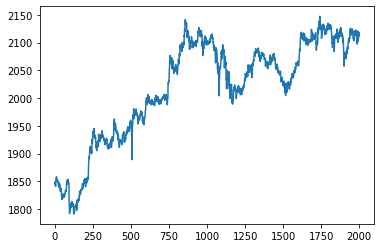

In [ ]:
plt.plot(list(P_ETH))
# plt.figsize(20,7)

Next, we will define an initial balance composed by 50000 units of ETH, a market price of P_ETH[0] and the corresponding units of USDC (50% each token at first).

Moreover, using new_balance y balances_changes functions we calculate how the balances would change if it changed for every new price (5m).

Note that in real life the balance won't necessarily change for every new market price (but when traders/arbitrators decide to operate it), but we want to reflect the underlying dynamics of Balancer.

In [ ]:
P_entry = P_ETH[0]
initial_balance = [P_entry*50000, 50000]
weight_USDC = 0.5
weight_ETH = 0.5
swap_fee = 0
new_balances_ = [initial_balance]
balance_changes_pcg = [[0,0]]
balance_changes_units = [[0,0]]
for i in range(1,len(P_ETH)):
  new_market_price = P_ETH[i]
  pool_price = calc_spot_price(new_balances_[i-1][0], weight_USDC,
                    new_balances_[i-1][1], weight_ETH,
                    swap_fee)
  if new_market_price < pool_price: # ETH has a lower market price, so the pool has to increase the balance of ETH
    new_balance_in, new_balance_out = list(new_balance(new_balances_[i-1][1], # token_in = ETH
                new_balances_[i-1][0], # token_out = USDC
                new_market_price,
                weight_ETH,
                weight_USDC,
                swap_fee).values())
    new_balances_.append([new_balance_in, new_balance_out])
  else:
    new_balance_in, new_balance_out = list(new_balance(new_balances_[i-1][0], # token_in = USDC
                new_balances_[i-1][1], # token_out = ETH
                new_market_price,
                weight_USDC,
                weight_ETH,
                swap_fee).values())
    new_balances_.append([new_balance_in, new_balance_out])
  # balance_changes_pcg.append(balances_changes(new_balances_[i], new_balances_[i-1])['pcg'])
  # balance_changes_units.append(balances_changes(new_balances_[i], new_balances_[i-1])['units'])

We check that new_balances_ variation coincides with theoretical variations.

In [ ]:
i = 1
new_balances_[i][0]/new_balances_[i-1][0] -1, balance_changes_pcg[i][0]

IndexError: ignored

Let's see how the balances change and check that market_spot = pool_spot.

In [ ]:
historical_balances = pd.DataFrame(new_balances_, index = P_ETH.index)
historical_balances.columns = ['balance_USDC', 'balance_ETH']
comparacion_precios = pd.concat([P_ETH, 
                             pd.DataFrame([calc_spot_price(new_balances_[i][0], weight_USDC,
                    new_balances_[i][1], weight_ETH,
                    swap_fee) for i in range(len(new_balances_))], index = P_ETH.index)], axis = 1)
          #  pd.DataFrame([V_hold[i]-V_hold_2[i] for i in range(len(V_pool))], index = P_ETH.index)], axis = 1)
comparacion_precios.columns = ['market_spot', 'pool_spot']
pd.concat([historical_balances, comparacion_precios], axis = 1)

,balance_USDC,balance_ETH,market_spot,pool_spot
timestamp,,,,
2021-03-31 00:00:00,9.226750e+07,50000.000000,1845.35,1845.35
2021-03-31 00:05:00,9.229100e+07,49987.270152,1846.29,1846.29
2021-03-31 00:10:00,9.235771e+07,49951.164928,1848.96,1848.96
2021-03-31 00:15:00,9.232123e+07,49970.898161,1847.5,1847.50
2021-03-31 00:20:00,9.228375e+07,49991.196408,1846.0,1846.00
...,...,...,...,...
2021-04-06 22:15:00,9.863784e+07,46770.844061,2108.96,2108.96
2021-04-06 22:20:00,9.880654e+07,46690.989319,2116.18,2116.18
2021-04-06 22:25:00,9.870213e+07,46740.380190,2111.71,2111.71


# Dynamic weights

We know that by reducing the weight of a token, we are incentivizing traders/arbitrators to buy it, i.e. to swap it for the other token. Therefore, decreasing one token's weight and increasing the other will likely increase the first's balance and decrease the second's balance.

The idea is to start a pool with almost all the weight concentrated in ETH, in order to incentivize arbitrators to swap their USDC for our ETH and therefore increasing our reserves of USDC. So, in a sense we will be selling ETH for USDC. We will keep the incentive like this (THINK HOW WEIGHTS SHOULD CHANGE) until ETH goes back to the floor price. Once ETH's price is greater than the floor price we will change the weights in order to incentivize arbitrators to swap their ETH for our USDC, i.e. we will be buying back the ETH.

**<font color='red'>Problem</font>**: If we buy back the ETH for a price greater than the floor price, we will be losing money (sell_price <= floor price <= buy_price).

**<font color='green'>Possible solution</font>**: We could sell the ETH not at the floor price but some price slightly above that and buy it back at a slightly lower price than the floor price (buy_price = floor_price - \epsilon < sell_price = floor_price + \epsilon). We should define:
- a threshold (floor_price, floor_price + \delta] in which we trigger the selling strategy for a sell_price = floor_price + \epsilon < floor_price + \delta
- a threshold [floor_price -\delta, floor_price) in which we trigger the buying back strategy for a buy_price = floor_price - \epsilon > floor_price - \delta

This way, as price moves between [floor_price + \epsilon, floor_price + \delta] (resp. [floor_price - \delta, floor_price - \epsilon] ), we have time to wait for the arbitrators to act.

We have to define some criteria to avoid losing money at all costs, i.e. to avoid buying back ETH at a higger price than the sell_price.

In [ ]:
# This function is crucial. I return constant weights bc I'm just testing the code
def dynamic_weights(market_spot, pool_spot):
  weight_USDC, weight_ETH = 0.01, 0.99
  return [weight_USDC, weight_ETH]

In [ ]:
P_entry = P_ETH[0]
weight_USDC_initial = 0.01
weight_ETH_initial = 0.99
initial_balance = [P_entry*5*weight_USDC_initial, 5*weight_ETH_initial]
new_balances_ = [initial_balance]
balance_changes_pcg = [[0,0]]
balance_changes_units = [[0,0]]
for i in range(1,len(P_ETH)):
  new_market_price = P_ETH[i]
  pool_price = calc_spot_price(new_balances_[i-1][0], weight_USDC,
                    new_balances_[i-1][1], weight_ETH,
                    swap_fee)
  weight_USDC, weight_ETH = dynamic_weights(new_market_price, pool_price)
  swap_fee = 0
  if new_market_price < pool_price: # ETH has a lower market price, so the pool has to increase the balance of ETH
    new_balance_in, new_balance_out = list(new_balance(new_balances_[i-1][1], # token_in = ETH
                new_balances_[i-1][0], # token_out = USDC
                new_market_price,
                weight_ETH,
                weight_USDC,
                swap_fee).values())
    new_balances_.append([new_balance_in, new_balance_out])
  else:
    new_balance_in, new_balance_out = list(new_balance(new_balances_[i-1][0], # token_in = USDC
                new_balances_[i-1][1], # token_out = ETH
                new_market_price,
                weight_USDC,
                weight_ETH,
                swap_fee).values())
    new_balances_.append([new_balance_in, new_balance_out])
  # print(i)
  # balance_changes_pcg.append(balances_changes(new_balances_[i], new_balances_[i-1])['pcg'])
  # balance_changes_units.append(balances_changes(new_balances_[i], new_balances_[i-1])['units'])

ZeroDivisionError: ignored

In [ ]:
# normalized_usdc = new_balances_[2][0] / weight_USDC,
normalized_eth = new_balances_[2][1]/ weight_ETH,
# swap_fee
new_balances_[2]

In [ ]:
weight_USDC_initial = 0.01
weight_ETH_initial = 0.99
initial_balance = [P_entry*5*weight_USDC_initial, 5*weight_ETH_initial]
new_balances_ = [initial_balance]

In [ ]:
normalized_USDC = initial_balance[0] / weight_USDC
normalized_ETH = initial_balance[1] / weight_ETH
pool_price = normalized_USDC / normalized_ETH
normalized_USDC, normalized_ETH, pool_price

(9226.75, 5.0, 1845.35)

In [ ]:
del new_balances_[-1]

In [ ]:
i = 3
new_market_price = P_ETH[i]
pool_price = calc_spot_price(new_balances_[i-1][0], weight_USDC,
                  new_balances_[i-1][1], weight_ETH,
                  swap_fee)
weight_USDC, weight_ETH = dynamic_weights(new_market_price, pool_price)
swap_fee = 0
if new_market_price < pool_price: # ETH has a lower market price, so the pool has to increase the balance of ETH
  new_balance_in, new_balance_out = list(new_balance(new_balances_[i-1][1], # token_in = ETH
              new_balances_[i-1][0], # token_out = USDC
              new_market_price,
              weight_ETH,
              weight_USDC,
              swap_fee).values())
  new_balances_.append([new_balance_out, new_balance_in])
else:
  new_balance_in, new_balance_out = list(new_balance(new_balances_[i-1][0], # token_in = USDC
              new_balances_[i-1][1], # token_out = ETH
              new_market_price,
              weight_USDC,
              weight_ETH,
              swap_fee).values())
  new_balances_.append([new_balance_in, new_balance_out])
print(new_balances_, [new_market_price, pool_price])

[[92.2675, 4.95], [92.31402988151109, 4.949974791755141], [92.4461932532731, 4.949903260251188], [0.00022117832143919713, 5.753496204021758]] [1847.5, 1848.9599999999998]


In [ ]:
calc_spot_price(new_balances_[3][0], weight_USDC,
                  new_balances_[3][1], weight_ETH,
                  swap_fee)

0.00380579964703453

In [ ]:
normalized_USDC = new_balances_[3][0] / weight_USDC
normalized_ETH = new_balances_[3][1] / weight_ETH
pool_price = normalized_USDC / normalized_ETH
normalized_USDC, normalized_ETH, pool_price

(0.022117832143919713, 5.811612327294705, 0.00380579964703453)

In [ ]:
i = 3
P_ETH[i], calc_spot_price(new_balances_[i-1][0], weight_USDC,
                  new_balances_[i-1][1], weight_ETH,
                  swap_fee)

(1847.5, 1848.9599999999998)

In [ ]:
new_balance(new_balances_[i-1][1], # token_in = ETH
              new_balances_[i-1][0], # token_out = USDC
              P_ETH[i],
              weight_ETH,
              weight_USDC,
              swap_fee)

{'new_balance_in': 5.753496204021758,
 'new_balance_out': 3.1456629642434564e-05}

In [ ]:
A_i = calc_in_given_price(new_balances_[i-1][0], # token_out = USDC
              new_balances_[i-1][1], # token_in = ETH
              P_ETH[i],
              weight_ETH,
              weight_USDC,
              swap_fee)['token_amount_in']
A_o = calc_out_given_in(
            A_i, 
            new_balances_[i-1][1]+A_i, weight_ETH,
            new_balances_[i-1][0], weight_USDC,
            swap_fee)['token_amount_out']
A_i, A_o

(0.8035929437705706, 92.44597207495165)

In [ ]:
((new_balances_[i-1][0]-A_o)*weight_ETH) / ((new_balances_[i-1][1]+A_i)*weight_USDC)

0.00380579964703453

In [ ]:
92.4461932532731 - 92.44616179664345

3.1456629642434564e-05

In [ ]:
calc_in_given_price(new_balances_[i-1][0], # token_out = USDC
              new_balances_[i-1][1], # token_in = ETH
              P_ETH[i],
              weight_ETH,
              weight_USDC,
              swap_fee)['token_amount_in']

0.8035929437705706